## Setup

Import the github repository and move it into the local directory (also remove the defult samples directoy if it exists)

In [1]:
from getpass import getpass
import os

user = "Boyne272"
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

# clone the repo
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-8-miniproject-softmax.git repo
    
# move the repo up one
!mv repo/* .
!mv repo/.git .

# delete un needed stuff
!rm -r repo
!rm -r sample_data/

github password··········
Cloning into 'repo'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 296 (delta 53), reused 68 (delta 28), pack-reused 195
Receiving objects: 100% (296/296), 34.79 MiB | 23.20 MiB/s, done.
Resolving deltas: 100% (154/154), done.
mv: cannot move 'repo/data' to './data': Directory not empty
mv: cannot move 'repo/models' to './models': Directory not empty
mv: cannot move 'repo/spec' to './spec': Directory not empty
mv: cannot move 'repo/training' to './training': Directory not empty
mv: cannot move 'repo/.git' to './.git': Directory not empty
rm: cannot remove 'sample_data/': No such file or directory


Move to correct github branch

In [2]:
# !git checkout richard
# !git reset --hard
# !git pull origin richard
!ls -l
!git log

total 36
drwxr-xr-x 2 root root 4096 May 21 08:29 data
drwxr-xr-x 2 root root 4096 May 21 14:21 models
drwxr-xr-x 2 root root 4096 May 21 14:31 __pycache__
-rw-r--r-- 1 root root  771 May 21 14:47 README.md
drwxr-xr-x 2 root root 4096 May 21 14:21 spec
-rw-r--r-- 1 root root 8812 May 21 14:47 tools.py
drwxr-xr-x 3 root root 4096 May 21 11:46 training
commit 301ae4522f77df94a35219a97bba2fb567aec263 (HEAD -> richard, origin/richard)
Author: Boyne272 <boynerichard@yahoo.co.uk>
Date:   Tue May 21 14:36:44 2019 +0100

    added mouse jiggle

commit 6e0faea1cae0670b24a01c8b00757a1fbae1953a
Author: jiaye-mao <610275388@qq.com>
Date:   Tue May 21 13:51:54 2019 +0100

    add result for LeNet5_basic

commit 183efb4fdd149f8048441234eacee5e98840d9be
Merge: 6b62c8a 6df00d6
Author: jiaye-mao <610275388@qq.com>
Date:   Tue May 21 13:50:14 2019 +0100

    Merge branch 'richard' of https://github.com/msc-acse/acse-8-miniproject-softmax into gary-mao

commit 6df00d62b118348bb87a664f30da7fe4402e34b6
Aut

Ipython imports and functions

In [3]:
# ipython setup
!pip install pycm livelossplot
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


Module imports

In [0]:
# imports
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, RandomCrop, ToPILImage, Pad

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

# imports from github
from tools import *

Check runtime device

In [5]:
# check running device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Load Data

In [0]:
train_feat = np.load("/content/data/kmnist-train-imgs.npy")
train_targ = np.load("/content/data/kmnist-train-labels.npy")
test_feat = np.load("/content/data/kmnist-test-imgs.npy")

In [7]:
# check what the data looks like
for data, data_name in zip([train_targ, test_feat, train_feat], 
                           ["train_targ", "test_feat", "train_feat"]):
    
    print(data_name)
    
    for name, code in zip(["shape", "mean", "std", "max", "min", "type", "cuda"],
                          ["data.shape", "data.mean()", "data.std()", 
                           "data.max()", "data.min()", "data.dtype"]):
        try:
            exec("print('\t', name, '\t:\t', " + code + ")")
        except:
            print("\t", name, "\t:\t undefined")

train_targ
	 shape 	:	 (60000,)
	 mean 	:	 4.5
	 std 	:	 2.8722813232690143
	 max 	:	 9
	 min 	:	 0
	 type 	:	 uint8
test_feat
	 shape 	:	 (10000, 28, 28)
	 mean 	:	 47.06204145408163
	 std 	:	 87.1110021912918
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8
train_feat
	 shape 	:	 (60000, 28, 28)
	 mean 	:	 48.89934757653061
	 std 	:	 88.82742173832395
	 max 	:	 255
	 min 	:	 0
	 type 	:	 uint8


Now set our parameters

In [0]:
# Other Hyperparameters
Seed = 42
Learning_Rate = 1e-2
Momentum = 0.5
Batch_Size = 64
Test_Batch_Size = 1000
Number_of_Epochs = 30

## Data pre-processing

In [0]:
def create_dataset(train, targ, t_id, v_id):
    
    # make trgets torch type and shape
    targ = torch.from_numpy(targ)
    targ = targ.long()
    # (features are changed in the transofrmations)
    
    # seperate the data
    t_feat = train[t_id]
    v_feat = train[v_id]
    t_targ = targ[t_id]
    v_targ = targ[v_id]
    
    # find mean and std
    mean, std = np.mean(t_feat)/255., np.std(t_feat)/255.
    print("avg:", mean, "std:", std)
    
    # includes data augmentation
    train_transform = Compose([
        ToTensor(),
        Normalize(mean=[mean], std=[std]),
        ])

    # only want to normalize here
    validation_test_transform = Compose([
        ToTensor(),
        Normalize(mean=[mean], std=[std]),
        ])
    
    # create the custom datasets
    train_set = CustomImageTensorDataset(t_feat, t_targ, transform=train_transform)
    valid_set = CustomImageTensorDataset(v_feat, v_targ, transform=validation_test_transform)

    return train_set, valid_set

Create the indicies for the data split

In [12]:
# do the split
n_folds = 10
shuffler =  StratifiedKFold(n_splits=n_folds, random_state=42, shuffle=True)
shuffler = shuffler.split(train_feat, train_targ)

# get the indices
indices = np.array(list(shuffler))
print(indices.shape)
print([i.shape for i in indices.flatten()])

(10, 2)
[(54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,), (54000,), (6000,)]


In [15]:
data_loders = []
for t_index, v_index in indices[:2]:
    t_set, v_set = create_dataset(train_feat, train_targ, t_index, v_index)
    data_loders.append([ DataLoader(t_set, batch_size=Batch_Size, shuffle=True),
                         DataLoader(v_set, batch_size=Test_Batch_Size, shuffle=False)])
    
data_loders = np.array(data_loders)
data_loders.shape

avg: 0.19175344221021742 std: 0.34832968140463433
avg: 0.19174826226787012 std: 0.3483234148893105


(2, 2)

Plot me some data

Loaded Feature Shape: torch.Size([64, 1, 28, 28])
Loaded Target Shape: torch.Size([64])
batch mean: tensor(0.0086)
batch std: tensor(0.9983)


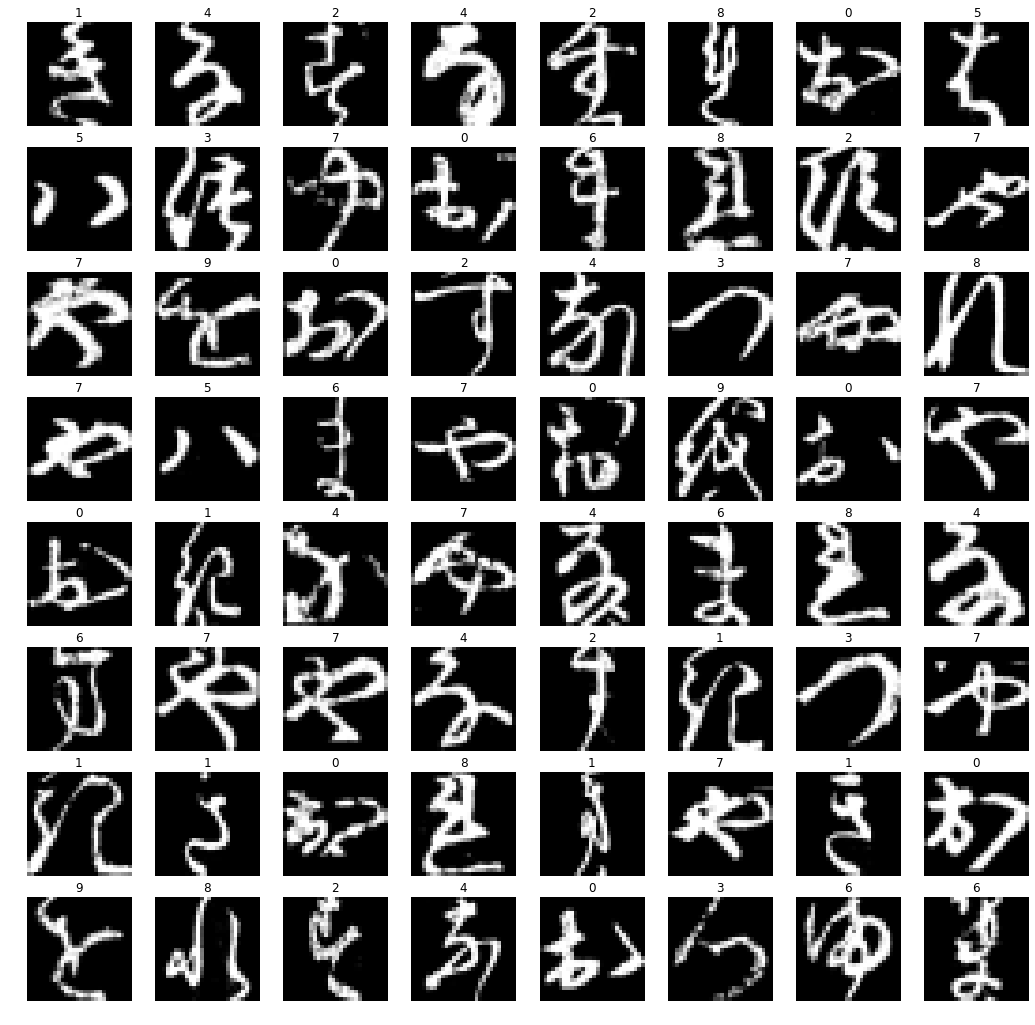

In [16]:
train_loader = data_loders[0, 0]
for X, y in train_loader:
    
    print("Loaded Feature Shape:", X.size())
    print("Loaded Target Shape:", y.size())
    print("batch mean:", X.mean())
    print("batch std:", X.std())
    
    fig, axs = plt.subplots(8, 8, figsize=[18, 18])
    
    for img, lab, ax in zip(X, y, axs.flatten()):
        ax.imshow(img[0], cmap='gray')
        ax.axis("off")
        ax.set(title=str(lab.item()))
    break

In [17]:
norm = data_loders[0, 1].dataset.transform
manual = [norm(t) for t in train_feat]
manual = torch.stack(manual)
manual.mean(), manual.std(), manual.size()

(tensor(2.1144e-05), tensor(1.0000), torch.Size([60000, 1, 28, 28]))

## Training the LeNet5 Model

First a sanity check

In [0]:
x = torch.randn((1, 1, 28, 28))
test_model = LeNet5()
y = test_model(x)
print("Output (pre-softmax):\n", y.detach().numpy())
n_params = sum([t.detach().numpy().size for t in test_model.parameters()])
print("Number of model Parameters: ", n_params)

Output (pre-softmax):
 [[ 0.05693818 -0.07069923  0.07006929 -0.20006111  0.05587816 -0.12176653
   0.12666029 -0.05490433 -0.09893806  0.06134976]]
Number of model Parameters:  61706


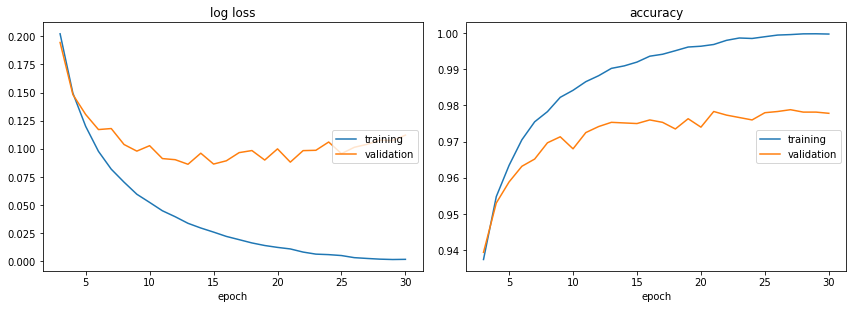

log loss:
training   (min:    0.001, max:    0.987, cur:    0.002)
validation (min:    0.086, max:    0.428, cur:    0.112)

accuracy:
training   (min:    0.682, max:    1.000, cur:    1.000)
validation (min:    0.865, max:    0.979, cur:    0.978)
Training Finished


In [0]:
set_seed(Seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=Learning_Rate, momentum=Momentum)
criterion = nn.CrossEntropyLoss()

wrapper = train_wrapper(model, optimizer, train_loader, validate_loader, validate_loader, criterion, device)
wrapper.train_model(Number_of_Epochs)

In [0]:
wrapper = train_wrapper(model, optimizer, train_loader, validate_loader, test_loader, criterion, device)

In [0]:
output = wrapper.evaluate()
print(output)
# save_csv(output, "LeNet5_test")

[2 9 3 ... 9 4 2]
